In [2]:
import datetime as dt
import pandas as pd
import numpy as np

## Determine URLs needed to extract Turnstile Data
##### Date Range: 
>April to May (2016 to 2019)

In [2]:
url_prefix = 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_'

In [13]:
start_date = '160402'
date = dt.date(int(start_date[:2]), int(start_date[2:4]), int(start_date[4:]))

In [14]:
date2 = date + dt.timedelta(days=7)

In [15]:
str(date2)[2:4]+str(date2)[5:7]+str(date2)[8:]

'160409'

In [30]:
# Create list of dates (by week) from April to end of May 2016
date_txt_2016 = '160402'
date_2016 = dt.date(int(start_date[:2]), int(start_date[2:4]), int(start_date[4:]))

date_list = [date_txt_2016]

In [31]:
    
while date_2016 < dt.date(16,6,1):
    date_2016 += dt.timedelta(days=7)
    date_list.append(str(date_2016)[2:4]+str(date_2016)[5:7]+str(date_2016)[8:])


In [33]:
date_list

['160402',
 '160409',
 '160416',
 '160423',
 '160430',
 '160507',
 '160514',
 '160521',
 '160528',
 '160604']

In [ ]:
urls = []
for date in date_list:
        
    

## Data Frame to Summarize Turnstile Entries & Exits

In [5]:
# Read pickled datafile
turnstile_df = pd.read_pickle('data.pkl')

In [6]:
turnstile_df['ENTRIES'] = turnstile_df['ENTRIES'].astype(np.int)
turnstile_df['EXITS'] = turnstile_df['EXITS'].astype(np.int)
turnstile_df['DATE'] = turnstile_df['DATE'].astype('datetime64[ns]')

In [9]:
turnstile_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10303675 entries, 0 to 10303674
Data columns (total 11 columns):
C/A         object
UNIT        object
SCP         object
STATION     object
LINENAME    object
DIVISION    object
DATE        datetime64[ns]
TIME        object
DESC        object
ENTRIES     int64
EXITS       int64
dtypes: datetime64[ns](1), int64(2), object(8)
memory usage: 864.7+ MB


In [8]:
turnstile_df.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS'],
      dtype='object')

#### Extract Date & Time Features:

In [21]:
date = pd.to_datetime(turnstile_df['DATE'], format='%m/%d/%Y')
time = pd.to_datetime(turnstile_df['TIME'], format='%H:%M:%S')

turnstile_df['year'] = date.dt.year
turnstile_df['month'] = date.dt.month
turnstile_df['day_of_week'] = date.dt.weekday
turnstile_df['hour'] = time.dt.hour
turnstile_df['minute'] = time.dt.minute

In [37]:
# Create concatenated field for Turnstile Key (UNIT + SCP)
turnstile_df.insert(0, 'TURNSTILE', turnstile_df['UNIT']+'|'+turnstile_df['SCP'])

In [43]:
# Create field to flag weekday or weekend transactions
turnstile_df.loc[turnstile_df['day_of_week'] < 5, 'WD vs WE'] = 'WD'
turnstile_df.loc[turnstile_df['day_of_week'] > 4, 'WD vs WE'] = 'WE'

In [46]:
turnstile_df.head(10)

,TURNSTILE,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,year,month,day_of_week,hour,minute,WD vs WE
0,R051|02-00-00,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-03-23,00:00:00,REGULAR,6989774,2370411,2019,3,5,0,0,WE
1,R051|02-00-00,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-03-23,04:00:00,REGULAR,6989795,2370413,2019,3,5,4,0,WE
2,R051|02-00-00,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-03-23,08:00:00,REGULAR,6989813,2370436,2019,3,5,8,0,WE
3,R051|02-00-00,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-03-23,12:00:00,REGULAR,6989924,2370512,2019,3,5,12,0,WE
4,R051|02-00-00,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-03-23,16:00:00,REGULAR,6990200,2370573,2019,3,5,16,0,WE
5,R051|02-00-00,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-03-23,20:00:00,REGULAR,6990562,2370623,2019,3,5,20,0,WE
6,R051|02-00-00,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-03-24,00:00:00,REGULAR,6990734,2370648,2019,3,6,0,0,WE
7,R051|02-00-00,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-03-24,04:00:00,REGULAR,6990758,2370653,2019,3,6,4,0,WE
8,R051|02-00-00,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-03-24,08:00:00,REGULAR,6990772,2370676,2019,3,6,8,0,WE
9,R051|02-00-00,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-03-24,12:00:00,REGULAR,6990860,2370731,2019,3,6,12,0,WE


# Calculate number of entries in each time period (`entries_delta`)

- Group DataFrame by turnstile and sort by date
- Define an appropriate time period
- Check for inconsistent data

In order to identify unique turnstiles, we use two key definitions from the [MTA transit toolkit](http://transitdatatoolkit.com/lessons/subway-turnstile-data/):

- `UNIT`: The remote unit is a collection of turnstiles... there can be multiple remote units one station
- `SCP`: Subunit channel position represents a turnstile... the same number can be used at different stations

Together, `UNIT` and `SCP` make a unique identifier for NYC turnstiles. 

In [66]:
# Create dataframe that consolidates each Turnstile (Unit + SCP); take the max entries & exits
# This will be used to determine the difference between Entries & Exits for each day
cons_turnstile_df = turnstile_df    \
                        .groupby(['TURNSTILE', 'STATION', 'DATE', 'year', 'hour', 'WD vs WE'])    \
                        .agg({'ENTRIES':'max', 'EXITS':'max'}).reset_index()

In [68]:
cons_turnstile_df.sort_values(['TURNSTILE', 'STATION', 'DATE', 'year', 'hour', 'WD vs WE'], inplace=True)

In [69]:
cons_turnstile_df.head(10)

,TURNSTILE,STATION,DATE,year,hour,WD vs WE,ENTRIES,EXITS
0,R001|00-00-00,WHITEHALL S-FRY,2016-02-27,2016,0,WE,1699119,1615179
1,R001|00-00-00,WHITEHALL S-FRY,2016-02-27,2016,4,WE,1699131,1615186
2,R001|00-00-00,WHITEHALL S-FRY,2016-02-27,2016,8,WE,1699154,1615191
3,R001|00-00-00,WHITEHALL S-FRY,2016-02-27,2016,12,WE,1699294,1615253
4,R001|00-00-00,WHITEHALL S-FRY,2016-02-27,2016,16,WE,1699516,1615328
5,R001|00-00-00,WHITEHALL S-FRY,2016-02-27,2016,20,WE,1699746,1615404
6,R001|00-00-00,WHITEHALL S-FRY,2016-02-28,2016,0,WE,1699792,1615423
7,R001|00-00-00,WHITEHALL S-FRY,2016-02-28,2016,4,WE,1699799,1615426
8,R001|00-00-00,WHITEHALL S-FRY,2016-02-28,2016,8,WE,1699817,1615432
9,R001|00-00-00,WHITEHALL S-FRY,2016-02-28,2016,12,WE,1699887,1615472


In [70]:
cons_turnstile_df['Entries Delta'] = cons_turnstile_df['ENTRIES']    \
                                            .rolling(2)    \
                                            .apply(lambda x: x[1]-x[0] if abs(x[1]-x[0]) < 5000 else np.nan ,raw=True)


In [71]:
cons_turnstile_df.head(10)

,TURNSTILE,STATION,DATE,year,hour,WD vs WE,ENTRIES,EXITS,Entries Delta
0,R001|00-00-00,WHITEHALL S-FRY,2016-02-27,2016,0,WE,1699119,1615179,NaN
1,R001|00-00-00,WHITEHALL S-FRY,2016-02-27,2016,4,WE,1699131,1615186,12.0
2,R001|00-00-00,WHITEHALL S-FRY,2016-02-27,2016,8,WE,1699154,1615191,23.0
3,R001|00-00-00,WHITEHALL S-FRY,2016-02-27,2016,12,WE,1699294,1615253,140.0
4,R001|00-00-00,WHITEHALL S-FRY,2016-02-27,2016,16,WE,1699516,1615328,222.0
5,R001|00-00-00,WHITEHALL S-FRY,2016-02-27,2016,20,WE,1699746,1615404,230.0
6,R001|00-00-00,WHITEHALL S-FRY,2016-02-28,2016,0,WE,1699792,1615423,46.0
7,R001|00-00-00,WHITEHALL S-FRY,2016-02-28,2016,4,WE,1699799,1615426,7.0
8,R001|00-00-00,WHITEHALL S-FRY,2016-02-28,2016,8,WE,1699817,1615432,18.0
9,R001|00-00-00,WHITEHALL S-FRY,2016-02-28,2016,12,WE,1699887,1615472,70.0


In [72]:
cons_turnstile_df[cons_turnstile_df['Entries Delta'] < 0]

,TURNSTILE,STATION,DATE,year,hour,WD vs WE,ENTRIES,EXITS,Entries Delta
61519,R001|02-06-01,SOUTH FERRY,2016-02-27,2016,0,WE,1,167,-1781.0
64824,R001|02-06-03,SOUTH FERRY,2018-02-24,2018,0,WE,2,23,-190.0
67042,R001|02-06-05,SOUTH FERRY,2018-02-24,2018,0,WE,1,26,-178.0
120368,R007|00-00-02,104 ST,2016-02-27,2016,7,WE,2026156755,622219189,-31.0
120369,R007|00-00-02,104 ST,2016-02-27,2016,11,WE,2026156690,622219172,-65.0
...,...,...,...,...,...,...,...,...,...
10145765,R552|00-01-00,JOURNAL SQUARE,2017-04-08,2017,11,WE,370,263,-2649.0
10145836,R552|00-01-00,JOURNAL SQUARE,2017-04-20,2017,21,WD,127,1384,-1924.0
10149512,R552|00-01-02,JOURNAL SQUARE,2018-05-09,2018,11,WD,2,0,-7.0
10149521,R552|00-01-02,JOURNAL SQUARE,2018-05-11,2018,12,WD,166,58,-148.0


In [73]:
cons_turnstile_df.iloc[120360:120375, :]

,TURNSTILE,STATION,DATE,year,hour,WD vs WE,ENTRIES,EXITS,Entries Delta
120360,R007|00-00-01,104 ST,2019-05-23,2019,20,WD,1121292500,1907495231,57.0
120361,R007|00-00-01,104 ST,2019-05-24,2019,0,WD,1121292518,1907495171,18.0
120362,R007|00-00-01,104 ST,2019-05-24,2019,4,WD,1121292523,1907495166,5.0
120363,R007|00-00-01,104 ST,2019-05-24,2019,8,WD,1121292725,1907495133,202.0
120364,R007|00-00-01,104 ST,2019-05-24,2019,12,WD,1121292859,1907495096,134.0
120365,R007|00-00-01,104 ST,2019-05-24,2019,16,WD,1121292940,1907495022,81.0
120366,R007|00-00-01,104 ST,2019-05-24,2019,20,WD,1121293020,1907494900,80.0
120367,R007|00-00-02,104 ST,2016-02-27,2016,3,WE,2026156786,622219196,NaN
120368,R007|00-00-02,104 ST,2016-02-27,2016,7,WE,2026156755,622219189,-31.0
120369,R007|00-00-02,104 ST,2016-02-27,2016,11,WE,2026156690,622219172,-65.0


In [104]:
cons_turnstile_df2 = cons_turnstile_df.copy()
cons_turnstile_df2.drop(columns=['Entries Delta'], inplace=True)

In [110]:
cons_turnstile_df2['Entries Delta'] = cons_turnstile_df2.groupby(['TURNSTILE', 'year'])['ENTRIES']    \
                        .apply(lambda x: x.rolling(2)    \
                        .apply(lambda x: x[1] - x[0] if ((x[1] - x[0]) >= 0) and    \
                               ((x[1] - x[0]) <= 4800) else np.nan, raw=True))

In [113]:
cons_turnstile_df2['Exits Delta'] = cons_turnstile_df2.groupby(['TURNSTILE', 'year'])['EXITS']    \
                        .apply(lambda x: x.rolling(2)    \
                        .apply(lambda x: x[1] - x[0] if ((x[1] - x[0]) >= 0) and    \
                               ((x[1] - x[0]) <= 4800) else np.nan, raw=True))

In [114]:
cons_turnstile_df2['Cum. Entries & Exits'] = cons_turnstile_df2['Entries Delta'] + cons_turnstile_df2['Exits Delta']

In [168]:
cons_turnstile_df2.head(10)

,TURNSTILE,STATION,DATE,year,hour,WD vs WE,ENTRIES,EXITS,Entries Delta,Exits Delta,Cum. Entries & Exits
0,R001|00-00-00,WHITEHALL S-FRY,2016-02-27,2016,0,WE,1699119,1615179,NaN,NaN,NaN
1,R001|00-00-00,WHITEHALL S-FRY,2016-02-27,2016,4,WE,1699131,1615186,12.0,7.0,19.0
2,R001|00-00-00,WHITEHALL S-FRY,2016-02-27,2016,8,WE,1699154,1615191,23.0,5.0,28.0
3,R001|00-00-00,WHITEHALL S-FRY,2016-02-27,2016,12,WE,1699294,1615253,140.0,62.0,202.0
4,R001|00-00-00,WHITEHALL S-FRY,2016-02-27,2016,16,WE,1699516,1615328,222.0,75.0,297.0
5,R001|00-00-00,WHITEHALL S-FRY,2016-02-27,2016,20,WE,1699746,1615404,230.0,76.0,306.0
6,R001|00-00-00,WHITEHALL S-FRY,2016-02-28,2016,0,WE,1699792,1615423,46.0,19.0,65.0
7,R001|00-00-00,WHITEHALL S-FRY,2016-02-28,2016,4,WE,1699799,1615426,7.0,3.0,10.0
8,R001|00-00-00,WHITEHALL S-FRY,2016-02-28,2016,8,WE,1699817,1615432,18.0,6.0,24.0
9,R001|00-00-00,WHITEHALL S-FRY,2016-02-28,2016,12,WE,1699887,1615472,70.0,40.0,110.0


In [169]:
# Create Key in cons_turnstile_df2 for TURNSTILE + hour
cons_turnstile_df2['TURNSTILE'] = cons_turnstile_df2['TURNSTILE'].astype(str)
cons_turnstile_df2['hour'] = cons_turnstile_df2['hour'].astype(str)
cons_turnstile_df2['turnstile_hour_key'] = cons_turnstile_df2['TURNSTILE'] + '|' + cons_turnstile_df2['hour']
cons_turnstile_df2.head(10)

,TURNSTILE,STATION,DATE,year,hour,WD vs WE,ENTRIES,EXITS,Entries Delta,Exits Delta,Cum. Entries & Exits,turnstile_hour_key
0,R001|00-00-00,WHITEHALL S-FRY,2016-02-27,2016,0,WE,1699119,1615179,NaN,NaN,NaN,R001|00-00-00|0
1,R001|00-00-00,WHITEHALL S-FRY,2016-02-27,2016,4,WE,1699131,1615186,12.0,7.0,19.0,R001|00-00-00|4
2,R001|00-00-00,WHITEHALL S-FRY,2016-02-27,2016,8,WE,1699154,1615191,23.0,5.0,28.0,R001|00-00-00|8
3,R001|00-00-00,WHITEHALL S-FRY,2016-02-27,2016,12,WE,1699294,1615253,140.0,62.0,202.0,R001|00-00-00|12
4,R001|00-00-00,WHITEHALL S-FRY,2016-02-27,2016,16,WE,1699516,1615328,222.0,75.0,297.0,R001|00-00-00|16
5,R001|00-00-00,WHITEHALL S-FRY,2016-02-27,2016,20,WE,1699746,1615404,230.0,76.0,306.0,R001|00-00-00|20
6,R001|00-00-00,WHITEHALL S-FRY,2016-02-28,2016,0,WE,1699792,1615423,46.0,19.0,65.0,R001|00-00-00|0
7,R001|00-00-00,WHITEHALL S-FRY,2016-02-28,2016,4,WE,1699799,1615426,7.0,3.0,10.0,R001|00-00-00|4
8,R001|00-00-00,WHITEHALL S-FRY,2016-02-28,2016,8,WE,1699817,1615432,18.0,6.0,24.0,R001|00-00-00|8
9,R001|00-00-00,WHITEHALL S-FRY,2016-02-28,2016,12,WE,1699887,1615472,70.0,40.0,110.0,R001|00-00-00|12


##### NOTE:
**"cons_turnstile_df2"** to be used further down for merging with **"avg_volume_df"**

### CALCULATE THE AVERAGE VOLUME (by Turnstile for each hour timeslot)

In [128]:
cons_turnstile_df3 = cons_turnstile_df2.groupby(['TURNSTILE', 'STATION', 'DATE', 'WD vs WE', 'hour'])    \
                                       .agg({'Cum. Entries & Exits':'sum'}).reset_index()

In [167]:
cons_turnstile_df3['Cum. Entries & Exits'].isnull().sum()

0

In [155]:
# Create Key in cons_turnstile_df3 for TURNSTILE + hour
cons_turnstile_df3['TURNSTILE'] = cons_turnstile_df3['TURNSTILE'].astype(str)
cons_turnstile_df3['hour'] = cons_turnstile_df3['hour'].astype(str)
cons_turnstile_df3['turnstile_hour_key'] = cons_turnstile_df3['TURNSTILE'] + '|' + cons_turnstile_df3['hour']
cons_turnstile_df3

,TURNSTILE,STATION,DATE,WD vs WE,hour,Cum. Entries & Exits,turnstile_hour_key
0,R001|00-00-00,WHITEHALL S-FRY,2016-02-27,WE,0,0.0,R001|00-00-00|0
1,R001|00-00-00,WHITEHALL S-FRY,2016-02-27,WE,4,19.0,R001|00-00-00|4
2,R001|00-00-00,WHITEHALL S-FRY,2016-02-27,WE,8,28.0,R001|00-00-00|8
3,R001|00-00-00,WHITEHALL S-FRY,2016-02-27,WE,12,202.0,R001|00-00-00|12
4,R001|00-00-00,WHITEHALL S-FRY,2016-02-27,WE,16,297.0,R001|00-00-00|16
...,...,...,...,...,...,...,...
10244275,R572|01-03-04,96 ST-2 AVE,2019-05-24,WD,8,360.0,R572|01-03-04|8
10244276,R572|01-03-04,96 ST-2 AVE,2019-05-24,WD,9,105.0,R572|01-03-04|9
10244277,R572|01-03-04,96 ST-2 AVE,2019-05-24,WD,13,342.0,R572|01-03-04|13
10244278,R572|01-03-04,96 ST-2 AVE,2019-05-24,WD,17,430.0,R572|01-03-04|17


In [154]:
# Create average_volume_df to contain average total entries & exits for each Turnstile for every hour timeslot
# Create Key in cons_turnstile_df3 for TURNSTILE + hour
average_volume_df = cons_turnstile_df3.groupby(['TURNSTILE', 'hour']).agg({'Cum. Entries & Exits':'mean'}).reset_index()
average_volume_df.rename(columns={'Cum. Entries & Exits': 'Mean Entries & Exits'}, inplace=True)
average_volume_df['TURNSTILE'] = average_volume_df['TURNSTILE'].astype(str)
average_volume_df['hour'] = average_volume_df['hour'].astype(str)
average_volume_df['turnstile_hour_key'] = average_volume_df['TURNSTILE'] + '|' + average_volume_df['hour']
average_volume_df.drop(columns=['TURNSTILE', 'hour'], inplace=True)
average_volume_df

,Mean Entries & Exits,turnstile_hour_key
0,224.343750,R001|00-00-00|0
1,206.832776,R001|00-00-00|1
2,58.883333,R001|00-00-00|4
3,57.115512,R001|00-00-00|5
4,212.800000,R001|00-00-00|7
...,...,...
79529,362.867841,R572|01-03-04|13
79530,322.066667,R572|01-03-04|16
79531,370.285088,R572|01-03-04|17
79532,458.155556,R572|01-03-04|20


### CREATE FINAL MERGED TABLE WITH ORIGINAL DATA + AVG ENTRIES & EXITS

In [170]:
cons_turnstile_df4 = pd.merge(cons_turnstile_df2, average_volume_df, on='turnstile_hour_key', how='left')
cons_turnstile_df4

,TURNSTILE,STATION,DATE,year,hour,WD vs WE,ENTRIES,EXITS,Entries Delta,Exits Delta,Cum. Entries & Exits,turnstile_hour_key,Mean Entries & Exits
0,R001|00-00-00,WHITEHALL S-FRY,2016-02-27,2016,0,WE,1699119,1615179,NaN,NaN,NaN,R001|00-00-00|0,224.343750
1,R001|00-00-00,WHITEHALL S-FRY,2016-02-27,2016,4,WE,1699131,1615186,12.0,7.0,19.0,R001|00-00-00|4,58.883333
2,R001|00-00-00,WHITEHALL S-FRY,2016-02-27,2016,8,WE,1699154,1615191,23.0,5.0,28.0,R001|00-00-00|8,334.128571
3,R001|00-00-00,WHITEHALL S-FRY,2016-02-27,2016,12,WE,1699294,1615253,140.0,62.0,202.0,R001|00-00-00|12,609.918033
4,R001|00-00-00,WHITEHALL S-FRY,2016-02-27,2016,16,WE,1699516,1615328,222.0,75.0,297.0,R001|00-00-00|16,552.770492
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10244275,R572|01-03-04,96 ST-2 AVE,2019-05-24,2019,8,WD,1087904,359253,302.0,58.0,360.0,R572|01-03-04|8,200.217391
10244276,R572|01-03-04,96 ST-2 AVE,2019-05-24,2019,9,WD,1087999,359263,95.0,10.0,105.0,R572|01-03-04|9,419.868996
10244277,R572|01-03-04,96 ST-2 AVE,2019-05-24,2019,13,WD,1088284,359320,285.0,57.0,342.0,R572|01-03-04|13,362.867841
10244278,R572|01-03-04,96 ST-2 AVE,2019-05-24,2019,17,WD,1088621,359413,337.0,93.0,430.0,R572|01-03-04|17,370.285088


In [172]:
cons_turnstile_df4[np.isnan(cons_turnstile_df4['Cum. Entries & Exits'])]

,TURNSTILE,STATION,DATE,year,hour,WD vs WE,ENTRIES,EXITS,Entries Delta,Exits Delta,Cum. Entries & Exits,turnstile_hour_key,Mean Entries & Exits
0,R001|00-00-00,WHITEHALL S-FRY,2016-02-27,2016,0,WE,1699119,1615179,NaN,NaN,NaN,R001|00-00-00|0,224.343750
551,R001|00-00-00,WHITEHALL S-FRY,2017-02-25,2017,0,WE,2243265,1838586,NaN,NaN,NaN,R001|00-00-00|0,224.343750
1102,R001|00-00-00,WHITEHALL S-FRY,2018-02-24,2018,0,WE,3097287,2197711,NaN,NaN,NaN,R001|00-00-00|0,224.343750
1647,R001|00-00-00,WHITEHALL S-FRY,2019-02-23,2019,0,WE,4104196,2551855,NaN,NaN,NaN,R001|00-00-00|0,224.343750
2199,R001|00-00-01,WHITEHALL S-FRY,2016-02-27,2016,0,WE,1411875,1122986,NaN,NaN,NaN,R001|00-00-01|0,216.687500
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10241547,R572|01-03-03,96 ST-2 AVE,2018-02-24,2018,0,WE,322786,220740,NaN,NaN,NaN,R572|01-03-03|0,147.875000
10242095,R572|01-03-03,96 ST-2 AVE,2019-02-23,2019,0,WE,574398,410054,NaN,NaN,NaN,R572|01-03-03|0,147.875000
10242641,R572|01-03-04,96 ST-2 AVE,2017-02-25,2017,0,WE,64198,17592,NaN,NaN,NaN,R572|01-03-04|0,173.520833
10243186,R572|01-03-04,96 ST-2 AVE,2018-02-24,2018,0,WE,517237,167474,NaN,NaN,NaN,R572|01-03-04|0,173.520833


### REPLACE ALL NaN Values in "Cum. Entries & Exits" with MEAN

In [173]:
cons_turnstile_df5 = cons_turnstile_df4.copy()

In [174]:
cons_turnstile_df5.loc[np.isnan(cons_turnstile_df5['Cum. Entries & Exits']),    \
                                            'Cum. Entries & Exits'] = cons_turnstile_df5['Mean Entries & Exits']

In [183]:
cons_turnstile_df5['hour'] = cons_turnstile_df5['hour'].astype(int)

In [191]:
cons_turnstile_df5

,TURNSTILE,STATION,DATE,year,hour,WD vs WE,ENTRIES,EXITS,Entries Delta,Exits Delta,Cum. Entries & Exits,turnstile_hour_key,Mean Entries & Exits
0,R001|00-00-00,WHITEHALL S-FRY,2016-02-27,2016,0,WE,1699119,1615179,NaN,NaN,224.34375,R001|00-00-00|0,224.343750
1,R001|00-00-00,WHITEHALL S-FRY,2016-02-27,2016,4,WE,1699131,1615186,12.0,7.0,19.00000,R001|00-00-00|4,58.883333
2,R001|00-00-00,WHITEHALL S-FRY,2016-02-27,2016,8,WE,1699154,1615191,23.0,5.0,28.00000,R001|00-00-00|8,334.128571
3,R001|00-00-00,WHITEHALL S-FRY,2016-02-27,2016,12,WE,1699294,1615253,140.0,62.0,202.00000,R001|00-00-00|12,609.918033
4,R001|00-00-00,WHITEHALL S-FRY,2016-02-27,2016,16,WE,1699516,1615328,222.0,75.0,297.00000,R001|00-00-00|16,552.770492
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10244275,R572|01-03-04,96 ST-2 AVE,2019-05-24,2019,8,WD,1087904,359253,302.0,58.0,360.00000,R572|01-03-04|8,200.217391
10244276,R572|01-03-04,96 ST-2 AVE,2019-05-24,2019,9,WD,1087999,359263,95.0,10.0,105.00000,R572|01-03-04|9,419.868996
10244277,R572|01-03-04,96 ST-2 AVE,2019-05-24,2019,13,WD,1088284,359320,285.0,57.0,342.00000,R572|01-03-04|13,362.867841
10244278,R572|01-03-04,96 ST-2 AVE,2019-05-24,2019,17,WD,1088621,359413,337.0,93.0,430.00000,R572|01-03-04|17,370.285088


In [188]:
cons_turnstile_df5['hour'].unique()

array([ 0,  4,  8, 12, 16, 20,  5,  9, 13, 17, 21,  1,  7, 10, 11, 18, 19,
       14,  3, 15, 23,  6, 22,  2])

### Create new DF to remove rows with timestamp below 8am and above 8pm

In [194]:
cons_turnstile_df6 = cons_turnstile_df5[(cons_turnstile_df5['hour'] > 8) & (cons_turnstile_df5['hour'] < 20)]
cons_turnstile_df6['hour'].unique()

array([12, 16,  9, 13, 17, 10, 11, 18, 19, 14, 15])

In [195]:
cons_turnstile_df6

,TURNSTILE,STATION,DATE,year,hour,WD vs WE,ENTRIES,EXITS,Entries Delta,Exits Delta,Cum. Entries & Exits,turnstile_hour_key,Mean Entries & Exits
3,R001|00-00-00,WHITEHALL S-FRY,2016-02-27,2016,12,WE,1699294,1615253,140.0,62.0,202.0,R001|00-00-00|12,609.918033
4,R001|00-00-00,WHITEHALL S-FRY,2016-02-27,2016,16,WE,1699516,1615328,222.0,75.0,297.0,R001|00-00-00|16,552.770492
9,R001|00-00-00,WHITEHALL S-FRY,2016-02-28,2016,12,WE,1699887,1615472,70.0,40.0,110.0,R001|00-00-00|12,609.918033
10,R001|00-00-00,WHITEHALL S-FRY,2016-02-28,2016,16,WE,1700070,1615557,183.0,85.0,268.0,R001|00-00-00|16,552.770492
15,R001|00-00-00,WHITEHALL S-FRY,2016-02-29,2016,12,WD,1700602,1615748,216.0,96.0,312.0,R001|00-00-00|12,609.918033
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10244270,R572|01-03-04,96 ST-2 AVE,2019-05-23,2019,13,WD,1086889,358862,291.0,62.0,353.0,R572|01-03-04|13,362.867841
10244271,R572|01-03-04,96 ST-2 AVE,2019-05-23,2019,17,WD,1087217,358945,328.0,83.0,411.0,R572|01-03-04|17,370.285088
10244276,R572|01-03-04,96 ST-2 AVE,2019-05-24,2019,9,WD,1087999,359263,95.0,10.0,105.0,R572|01-03-04|9,419.868996
10244277,R572|01-03-04,96 ST-2 AVE,2019-05-24,2019,13,WD,1088284,359320,285.0,57.0,342.0,R572|01-03-04|13,362.867841


In [201]:
cons_turnstile_df6

,TURNSTILE,STATION,DATE,year,hour,WD vs WE,Cum. Entries & Exits,Mean Entries & Exits
3,R001|00-00-00,WHITEHALL S-FRY,2016-02-27,2016,12,WE,202.0,609.918033
4,R001|00-00-00,WHITEHALL S-FRY,2016-02-27,2016,16,WE,297.0,552.770492
9,R001|00-00-00,WHITEHALL S-FRY,2016-02-28,2016,12,WE,110.0,609.918033
10,R001|00-00-00,WHITEHALL S-FRY,2016-02-28,2016,16,WE,268.0,552.770492
15,R001|00-00-00,WHITEHALL S-FRY,2016-02-29,2016,12,WD,312.0,609.918033
...,...,...,...,...,...,...,...,...
10244270,R572|01-03-04,96 ST-2 AVE,2019-05-23,2019,13,WD,353.0,362.867841
10244271,R572|01-03-04,96 ST-2 AVE,2019-05-23,2019,17,WD,411.0,370.285088
10244276,R572|01-03-04,96 ST-2 AVE,2019-05-24,2019,9,WD,105.0,419.868996
10244277,R572|01-03-04,96 ST-2 AVE,2019-05-24,2019,13,WD,342.0,362.867841


In [266]:
cons_turnstile_df6['STATION'].unique()

array(['WHITEHALL S-FRY', 'SOUTH FERRY', 'CYPRESS HILLS', '75 ST-ELDERTS',
       '85 ST-FOREST PK', 'WOODHAVEN BLVD', '104 ST', '111 ST', '121 ST',
       '42 ST-PORT AUTH', '34 ST-PENN STA', 'FULTON ST', '5 AV/53 ST',
       'LEXINGTON AV/53', 'JKSN HT-ROOSVLT', '74 ST-BROADWAY',
       'JAMAICA 179 ST', '47-50 STS ROCK', '42 ST-BRYANT PK',
       '34 ST-HERALD SQ', 'SUTPHIN-ARCHER', 'JAMAICA CENTER', 'WALL ST',
       'PARK PLACE', 'WORLD TRADE CTR', 'CHAMBERS ST', 'TIMES SQ-42 ST',
       '125 ST', '168 ST', 'DYCKMAN ST', '207 ST', '215 ST',
       'MARBLE HILL-225', '231 ST', 'BOWLING GREEN', 'BROOKLYN BRIDGE',
       'GRD CNTRL-42 ST', '51 ST', '59 ST', 'WOODLAWN', '3 AV-149 ST',
       '5 AVE', 'FLUSHING-MAIN', 'NEVINS ST', 'ATL AV-BARCLAY',
       'BERGEN ST', 'GRAND ARMY PLAZ', 'EASTN PKWY-MUSM', 'NOSTRAND AV',
       'CROWN HTS-UTICA', 'SUTTER AV-RUTLD', 'SARATOGA AV', 'ROCKAWAY AV',
       'JUNIUS ST', 'PENNSYLVANIA AV', 'VAN SICLEN AV', 'NEW LOTS AV',
       'ST. GEORGE', '

## PLOTTING DATA:

In [204]:
import seaborn as sns
import matplotlib.pyplot as plt

#### Plot total entries & Exits by Station:

In [239]:
stations_total = cons_turnstile_df6.groupby('STATION').agg({'Cum. Entries & Exits':'sum'})
stations_total['Cum. Entries & Exits'] = stations_total['Cum. Entries & Exits']/1000
stations_total_top10 = stations_total.nlargest(10, 'Cum. Entries & Exits').reset_index()
stations_total_top10

,STATION,Cum. Entries & Exits
0,34 ST-PENN STA,55642.822712
1,GRD CNTRL-42 ST,48978.473121
2,34 ST-HERALD SQ,36274.289132
3,14 ST-UNION SQ,36227.743832
4,23 ST,34942.009571
5,FULTON ST,34492.813599
6,86 ST,29589.057257
7,TIMES SQ-42 ST,29037.767989
8,42 ST-PORT AUTH,27852.360092
9,125 ST,24922.893634


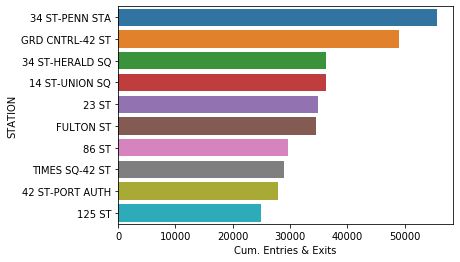

In [252]:
#stations_total_top10.plot(kind='bar', x='Cum. Entries & Exits', y='STATION')
sns.barplot(x='Cum. Entries & Exits', y='STATION', data=stations_total_top10)


#### Plot Day of Week against Time of day:

In [265]:
day_comp_total = cons_turnstile_df6.groupby(['WD vs WE', 'hour']).agg({'Cum. Entries & Exits':'sum'})
day_comp_total['Cum. Entries & Exits'] = day_comp_total['Cum. Entries & Exits']/1000000
day_comp_total = day_comp_total.reset_index()
day_comp_total

,WD vs WE,hour,Cum. Entries & Exits
0,WD,9,186.977850
1,WD,10,34.736977
2,WD,11,83.830794
3,WD,12,368.978272
4,WD,13,159.801535
5,WD,14,16.148703
6,WD,15,44.838326
7,WD,16,283.784255
8,WD,17,194.227162
9,WD,18,32.602071


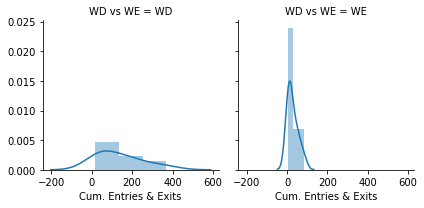

In [261]:
g = sns.FacetGrid(day_comp_total, col='WD vs WE', sharex=True, sharey=True)
g.map(sns.distplot, 'Cum. Entries & Exits',norm_hist=False);

From the above graphs we can see there is little variability in total entries/exits on the weekends based on the time of the day. In general there is very little volume on the weekends.

We can also see that there is a large variability in total entries/exits based on the time of day. Let's take a look below to determine what times of day dictate the highest traffic.

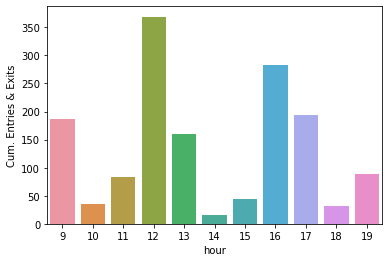

In [264]:
sns.barplot(x='hour', y='Cum. Entries & Exits', data=day_comp_total[day_comp_total['WD vs WE'] == 'WD'])